In [6]:
# import the serious stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

In [7]:
# create random images
no_of_images = 50000
image_size = 8
min_object_size = 1
max_object_size = 4
no_of_objects = 1 # number of squares in an image

# stores list of boundary of every object
bounding_boxes = np.zeros((no_of_images, no_of_objects, 4))

# list of images
images = np.zeros((no_of_images, image_size, image_size))

for i_image in range(no_of_images):
    for i_object in range(no_of_objects):
        # size is the no of random variables to be generated
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, image_size - w)
        y = np.random.randint(0, image_size - h)
        images[i_image, x:x+w, y:y+h] = 1.
        bounding_boxes[i_image, i_object] = [x, y, w, h]

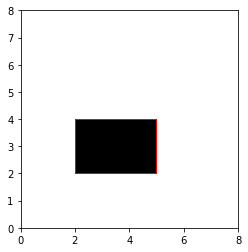

In [8]:
# debug
# .T does diagonal transform
plt.imshow(images[0].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
for bounding_box in bounding_boxes[0]:
    # apparently draws bounding boxes
    plt.gca().add_patch(matplotlib.patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2], bounding_box[3], ec='r', fc='none'))

In [10]:
# normalize data to mean 0 and std 1, -1 means dimension is unknown
X = (images.reshape(no_of_images, -1) - np.mean(images) / np.std(images))
print(X.shape, np.mean(X), np.std(X))

# normalize x, y, w, h by image_size, so all values are between 0 and 1
y = bounding_boxes.reshape(no_of_images, -1) / image_size
print(y.shape, np.mean(y), np.std(y))

(50000, 64) -0.19552953647753504 0.24180712013836428
(50000, 4) 0.281054375 0.17517067796397712


In [11]:
# split training and test dataset
split = int(0.8 * no_of_images)
train_X = X[:split]
test_X = X[split:]
train_y = y[:split]
test_y = y[split:]

# test images
test_images = images[split:]
test_boxes = bounding_boxes[split:]

In [14]:
# build the model
model = Sequential([
    Dense(200, input_dim=X.shape[-1]),
    Activation('relu'),
    Dropout(0.2),
    Dense(y.shape[-1])
])
model.compile('adadelta', 'mse')

In [16]:
# train the model
model.fit(train_X, train_y, epochs=30, validation_data=(test_X, test_y), verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
 - 2s - loss: 6.8532e-04 - val_loss: 4.8305e-05
Epoch 2/30
 - 2s - loss: 6.8230e-04 - val_loss: 7.4917e-05
Epoch 3/30
 - 2s - loss: 6.7230e-04 - val_loss: 4.6223e-05
Epoch 4/30
 - 2s - loss: 6.7354e-04 - val_loss: 4.8046e-05
Epoch 5/30
 - 2s - loss: 6.6591e-04 - val_loss: 4.4772e-05
Epoch 6/30
 - 2s - loss: 6.5618e-04 - val_loss: 4.7988e-05
Epoch 7/30
 - 2s - loss: 6.6021e-04 - val_loss: 6.2910e-05
Epoch 8/30
 - 2s - loss: 6.5382e-04 - val_loss: 4.4253e-05
Epoch 9/30
 - 2s - loss: 6.4927e-04 - val_loss: 4.0142e-05
Epoch 10/30
 - 2s - loss: 6.4906e-04 - val_loss: 5.5269e-05
Epoch 11/30
 - 2s - loss: 6.4442e-04 - val_loss: 4.4645e-05
Epoch 12/30
 - 2s - loss: 6.4795e-04 - val_loss: 4.1479e-05
Epoch 13/30
 - 2s - loss: 6.2917e-04 - val_loss: 4.8749e-05
Epoch 14/30
 - 2s - loss: 6.3329e-04 - val_loss: 5.9071e-05
Epoch 15/30
 - 2s - loss: 6.3285e-04 - val_loss: 3.2835e-05
Epoch 16/30
 - 2s - loss: 6.2969e-04 - val_loss: 4.4694e-05

In [21]:
# predict bounding boxes for test data
predicted_y = model.predict(test_X)
predicted_boxes = predicted_y * image_size
predicted_boxes = predicted_boxes.reshape(len(predicted_boxes), no_of_objects, -1)
predicted_boxes.shape

(10000, 1, 4)

In [ ]:
# calculate overlap between two bounding boxes
def IOU(box_1, box_2):
    x1, y1, w1, h1 = box_1[0], box_1[1], box_1[2], box_1[3]
    x2, y2, w2, h2 = box_2[0], box_2[1], box_2[2], box_2[3]